In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from matplotlib.patches import Rectangle
from itertools import chain
from sklearn.cluster import KMeans
from scipy.spatial.distance import euclidean as dist
from collections import defaultdict

## 0. Feladat: Kirajzolás előkészítése
Arc kereső és kirajzoló függvény

In [2]:
def plot_results(gray_images, results):
    for img, faces in zip(gray_images, result):
        plt.imshow(img, cmap="gray")
        for f in faces:
            rect = np.array([(f[0], f[1]), 
                             (f[0] + f[2], f[1]), 
                             (f[0] + f[2], f[1] + f[3]), 
                             (f[0], f[1] + f[3])])
            plt.fill(*rect.T, fill=False, linewidth=3, edgecolor="r")
        plt.show()

def find_faces(images, cascade_path):
    face_cascade = cv2.CascadeClassifier() 
    face_cascade.load(str(cascade_path))
    return [face_cascade.detectMultiScale(img) for img in images]

## 1. feladat: képek detektálása
Képek beolvasása és előkészítése

In [3]:
work_dir1 = Path('./Feladat1/')
gray_imgs = [cv2.equalizeHist(cv2.imread(str(p), cv2.IMREAD_GRAYSCALE)) for p in work_dir1.glob('*.jpg')]

#### A: Front képekkel való vizsgálat

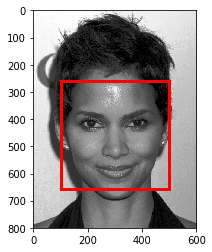

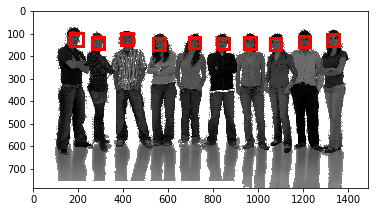

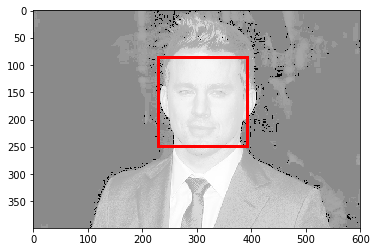

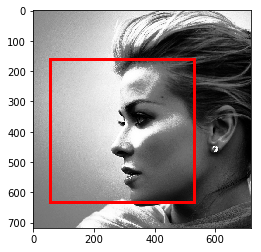

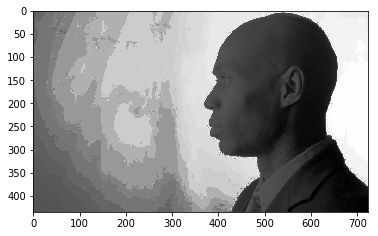

In [4]:
result = find_faces(gray_imgs, work_dir1 / 'haarcascade_frontalface_alt.xml')
plot_results(gray_imgs, result)

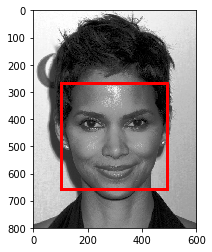

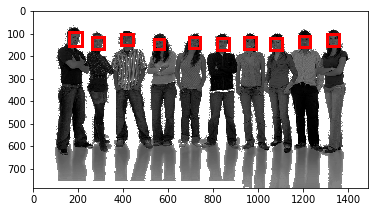

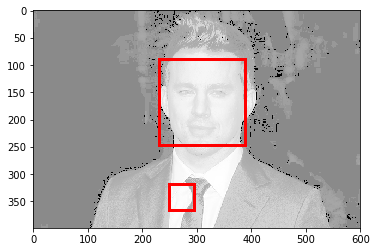

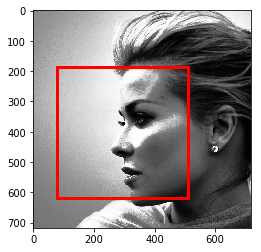

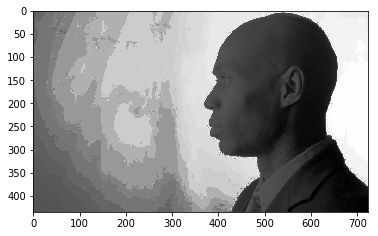

In [5]:
result = find_faces(gray_imgs, work_dir1 / 'haarcascade_frontalface_alt2.xml')
plot_results(gray_imgs, result)

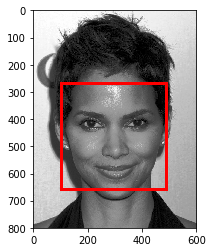

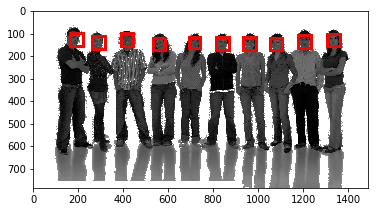

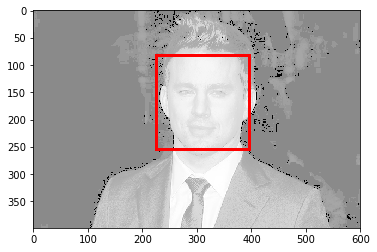

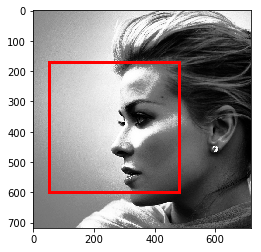

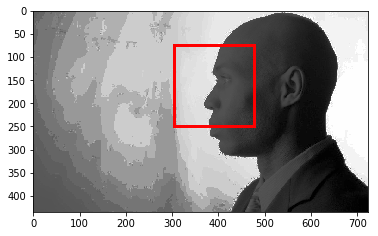

In [6]:
result = find_faces(gray_imgs, work_dir1 / 'lbpcascade_frontalface.xml')
plot_results(gray_imgs, result)

#### B: Profile adattal való vizsgálat

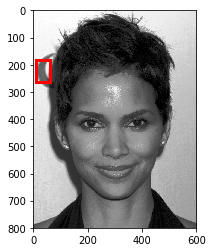

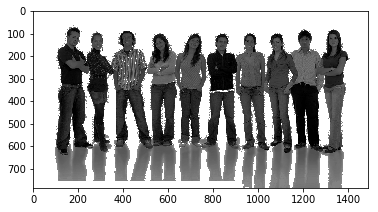

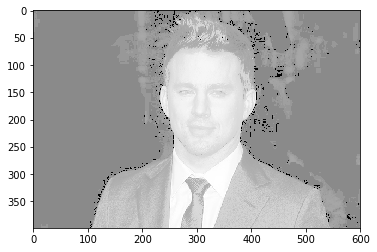

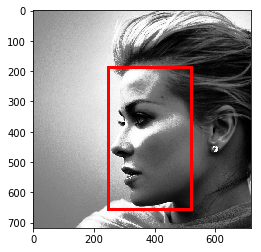

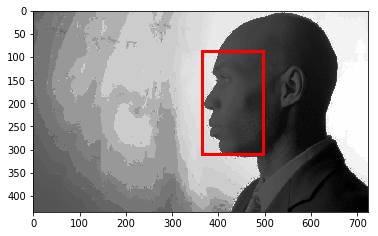

In [7]:
result = find_faces(gray_imgs, work_dir1 / 'lbpcascade_profileface.xml')
plot_results(gray_imgs, result)

## 2. feladat: videó feldolgozása

In [8]:
work_dir2 = Path('./Feladat2/')

#### A+B: Front és profile adattal való vizsgálat
Videó keretező függvény első verzió

In [114]:
def find_in_video(video_path, cascade_path, output_postfix=''):
    # prepare videos
    cap = cv2.VideoCapture(str(video_path))
    output_path = video_path.with_name(video_path.stem + output_postfix + '_tagged' + video_path.suffix)
    print(str(output_path))
    fourcc = cv2.VideoWriter_fourcc(*'XVID')
    out = cv2.VideoWriter(str(output_path), fourcc, 30.0, (856,480))
    
    # prepare classifier
    face_cascade = cv2.CascadeClassifier() 
    face_cascade.load(str(cascade_path))
    
    try:
        ret = True
        while(ret):
            ret, frame = cap.read()
            if ret is True:
                gray_img = cv2.equalizeHist(cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY))
                faces = face_cascade.detectMultiScale(gray_img)
                for f in faces:
                    a, b = f.reshape(-1,2)
                    cv2.rectangle(frame, tuple(a), tuple(a+b), (255,0,0), 3)
                out.write(frame)
    finally:
        cap.release()
        out.release()

Kipróbálás az összes cascade xml-lel

In [115]:
for i, cas_setting_path in enumerate(work_dir1.glob('*.xml')):
    print(i, cas_setting_path.name)
    find_in_video(work_dir2 / 'testvideo.avi', cas_setting_path, str(i))

0 haarcascade_frontalface_alt.xml
Feladat2\testvideo0_tagged.avi
1 haarcascade_frontalface_alt2.xml
Feladat2\testvideo1_tagged.avi
2 lbpcascade_frontalface.xml
Feladat2\testvideo2_tagged.avi
3 lbpcascade_profileface.xml
Feladat2\testvideo3_tagged.avi


## 3. feladat: a front és a profile adatok kombinálása
#### A: futtatás egyszerre

In [11]:
def find_in_video(video_path):
    # prepare videos
    cap = cv2.VideoCapture(str(video_path))
    fourcc = cv2.VideoWriter_fourcc(*'XVID')
    out = cv2.VideoWriter('front_profile.avi', fourcc, 30.0, (856,480))
    
    # prepare classifier
    face_cascade_front = cv2.CascadeClassifier() 
    face_cascade_front.load(str(work_dir1 / 'haarcascade_frontalface_alt.xml'))
    face_cascade_profile = cv2.CascadeClassifier() 
    face_cascade_profile.load(str(work_dir1 / 'lbpcascade_profileface.xml'))
    
    try:
        ret = True
        while(ret):
            ret, frame = cap.read()
            if ret is True:
                gray_img = cv2.equalizeHist(cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY))
                # scan with front
                faces = face_cascade_front.detectMultiScale(gray_img)
                for f in faces:
                    a, b = f.reshape(-1,2)
                    cv2.rectangle(frame, tuple(a), tuple(a+b), (255,0,0), 3)
                # scan with profile    
                faces = face_cascade_profile.detectMultiScale(gray_img)
                for f in faces:
                    a, b = f.reshape(-1,2)
                    cv2.rectangle(frame, tuple(a), tuple(a+b), (0,0,255), 3)
                out.write(frame)
    finally:
        cap.release()
        out.release()
find_in_video(work_dir2 / 'testvideo.avi')

#### B: minden arcot egyszer...

Kmeans az utóbbi 10 frame-ra, és mindig csak a két ceterhez legközelebbi boxok rajzolása

In [13]:
def find_in_video_fixed(video_path):
    # prepare videos
    cap = cv2.VideoCapture(str(video_path))
    fourcc = cv2.VideoWriter_fourcc(*'XVID')
    out = cv2.VideoWriter('front_profile_fixed.avi', fourcc, 30.0, (856,480))
    
    # prepare classifier
    face_cascade_front = cv2.CascadeClassifier() 
    face_cascade_front.load(str(work_dir1 / 'haarcascade_frontalface_alt.xml'))
    face_cascade_profile = cv2.CascadeClassifier() 
    face_cascade_profile.load(str(work_dir1 / 'lbpcascade_profileface.xml'))
    
    window_size = 20
    
    try:
        ret = True
        centers = []
        i = 0
        while(ret):
            ret, frame = cap.read()
            if ret is True:
                gray_img = cv2.equalizeHist(cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY))
                
                faces_front = face_cascade_front.detectMultiScale(gray_img)
                faces_profile = face_cascade_profile.detectMultiScale(gray_img)
                
                # add centers of detected tectangles to list
                current_boxes = [*faces_front, *faces_profile]
                current_centers = [b[:2] +  b[2:] / 2 for b in current_boxes]
                centers.append(current_centers)
                
                cluster_centers = None
                if len(centers) > window_size and len(sum(centers[-window_size:], [])) > 2:
                    kmns = KMeans(n_clusters=2)
                    kmns.fit(sum(centers[-window_size:], []))
                    cluster_centers = kmns.cluster_centers_
                    
                    distances = [[dist(cnt, kms_cnt) for cnt in current_centers] for kms_cnt in cluster_centers]
                    
                    for d in distances:
                        if len(d) > 0 and np.min(d) < 50:
                            a, b = current_boxes[np.argmin(d)].reshape(-1, 2)
                            cv2.rectangle(frame, tuple(a), tuple(a+b), (255,0,0), 3)
                    
                else:
                
                    for f in faces_front:
                        a, b = f.reshape(-1,2)
                        cv2.rectangle(frame, tuple(a), tuple(a+b), (255,0,0), 3)   

                    for f in faces_profile:
                        a, b = f.reshape(-1,2)
                        cv2.rectangle(frame, tuple(a), tuple(a+b), (0,0,255), 3)

                out.write(frame)
    finally:
        cap.release()
        out.release()

In [14]:
find_in_video_fixed(work_dir2 / 'testvideo.avi')

## 4. Pontosság értékelése
Függvények a referencia adatok beolvasására és a pontosság meghatározására

In [109]:
def get_ref_data():
    ref_txt = Path('./Feladat4/reference.txt').read_text()
    ref_all = np.array(ref_txt.split('\n')[:-1], dtype=int).reshape(-1, 4)
    return ref_all.shape[0], chain(ref[:238 * 2].reshape(-1, 8), ref[238 * 2:])

def check_if_match(target, test):
    mask1 = np.zeros((480, 856), dtype=bool)
    mask1[target[1]:target[3],target[0]:target[2]] = True
    mask2 = np.zeros((480, 856), dtype=bool)
    mask2[test[1]:test[3],test[0]:test[2]] = True
    return np.sum(mask1 & mask2) / np.sum(mask1) > 0.5

In [96]:
def find_in_video_fixed(video_path):
    # prepare videos
    cap = cv2.VideoCapture(str(video_path))
    fourcc = cv2.VideoWriter_fourcc(*'XVID')
    out = cv2.VideoWriter('front_profile_fixed_meas.avi', fourcc, 30.0, (856,480))
    
    # prepare classifier
    face_cascade_front = cv2.CascadeClassifier() 
    face_cascade_front.load(str(work_dir1 / 'haarcascade_frontalface_alt.xml'))
    face_cascade_profile = cv2.CascadeClassifier() 
    face_cascade_profile.load(str(work_dir1 / 'lbpcascade_profileface.xml'))
    
    window_size = 20
    
    try:
        ret = True
        centers = []
        detection_results = []
        i = 0
        _, data_gen = get_ref_data()
        while(ret):
            ret, frame = cap.read()
            if ret is True:
                if i < 238:
                    r1, r2 = next(data_gen).reshape(-1, 4)
                else:
                    r = next(data_gen)
                
                gray_img = cv2.equalizeHist(cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY))
                faces_front = face_cascade_front.detectMultiScale(gray_img)
                faces_profile = face_cascade_profile.detectMultiScale(gray_img)
                
                # add centers of detected tectangles to list
                current_boxes = [*faces_front, *faces_profile]
                current_centers = [b[:2] +  b[2:] / 2 for b in current_boxes]
                centers.append(current_centers)
                
                cluster_centers = None
                if len(centers) > window_size and len(sum(centers[-window_size:], [])) > 2:
                    kmns = KMeans(n_clusters=2)
                    kmns.fit(sum(centers[-window_size:], []))
                    cluster_centers = kmns.cluster_centers_
                    
                    distances = [[dist(cnt, kms_cnt) for cnt in current_centers] for kms_cnt in cluster_centers]
                    
                    for d in distances:
                        if len(d) > 0 and np.min(d) < 50:
                            a, b = current_boxes[np.argmin(d)].reshape(-1, 2)
                            cv2.rectangle(frame, tuple(a), tuple(a+b), (255,0,0), 3)
                            
                            if i < 238:
                                c_1 = check_if_match(r1, np.array([tuple(a), tuple(a+b)]).reshape(-1))
                                c_2 = check_if_match(r2, np.array([tuple(a), tuple(a+b)]).reshape(-1))
                                detection_results.append((i, c_1 | c_2))
                            else:
                                c_1 = check_if_match(r1, np.array([tuple(a), tuple(a+b)]).reshape(-1))
                                detection_results.append((i, c_1))
                    
                else:
                
                    for f in faces_front:
                        a, b = f.reshape(-1,2)
                        cv2.rectangle(frame, tuple(a), tuple(a+b), (255,0,0), 3)   

                    for f in faces_profile:
                        a, b = f.reshape(-1,2)
                        cv2.rectangle(frame, tuple(a), tuple(a+b), (0,0,255), 3)
                
                out.write(frame)
                i += 1
    finally:
        cap.release()
        out.release()
    return detection_results

In [97]:
res = find_in_video_fixed(work_dir2 / 'testvideo.avi')

Processing results

In [106]:
positive_detects = defaultdict(lambda: 0)
for i, is_success in res:
    if is_success:
        positive_detects[i] += 1
n_pos = sum(list(positive_detects.values()))

In [110]:
n_all, _ = get_ref_data()

In [112]:
n_pos / n_all

0.213089802130898